# **Social Networks & Online Markets: Homework 1**

**Author:** Miguel Ángel Sánchez Cortés

*MSc. in Data Science, Sapienza University of Rome*

In [1]:
#Here we import all the necessary libraries
import torch
import matplotlib
import networkx as nx
import seaborn as sns
from modules.eigen import *
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import curve_fit
import torch_geometric.transforms as T
from modules.bcm import BoundedConfidence
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from modules.gnn import NodeClassification, LinkPrediction
#Here we set the style of the plots
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('font', family='serif')
matplotlib.rcParams['text.usetex'] = True

## **Problem 2**

**Demonstrate (by calculating $\lambda_{2}$, $\phi(G)$. etc.) that Cheeger's inequalities hold for this graph.**

To obtain $\lambda_{2}$ we can use the `eigen.py` module to perform the following steps:

1. Obtain the adjacency matrix $A$ of our $4$-regular graph $G$.

2. Obtain the normalized Laplacian matrix $\mathcal{L}$ using $A$.

3. Calculate the second smallest eigenvalue of $\mathcal{L}$ and its corresponding eigenvector.

For the first step, we can make use of the `NetworkX` package:

In [4]:
#Here we create the edge list of the graph
edge_list = [(1,2), (1,3), (1,4), (1,7), (2,3), (2,4), (2,5), (3,4), (3,7), (4,5), (5,6), 
             (5,9), (6,8), (6,9), (6,10), (7,8), (7,10), (8,9), (8,10), (9,10)]

#Here we create the graph
G = nx.from_edgelist(edge_list)

#Here we obtain the adjacency matrix of the graph
A = nx.adjacency_matrix(G).todense()

For the second step, we can make use of the `normalized_laplacian` function of the `eigen.py` module:

In [5]:
#Here we obtain the normalized laplacian matrix of the graph
L = normalized_laplacian(A, 4)

For the third step, we can make use of the `second_smallest_eigenvalue` function of the `eigen.py` module:

In [6]:
#Here we obtain the second smallest eigenvalue and its corresponding eigenvector of the normalized laplacian matrix
second_smallest_eigenvalue, second_smallest_eigenvector = second_smallest_eigenvalue(L)

Finally, our results are:

In [7]:
print("The second smallest eigenvalue of the normalized laplacian matrix is:")
print(second_smallest_eigenvalue)
print("The corresponding eigenvector is:")
print(second_smallest_eigenvector)


The second smallest eigenvalue of the normalized laplacian matrix is:
0.25000000000000044
The corresponding eigenvector is:
[[-3.53553391e-01]
 [-3.53553391e-01]
 [-3.53553391e-01]
 [-3.53553391e-01]
 [ 1.88168481e-16]
 [ 2.69901686e-16]
 [ 3.53553391e-01]
 [ 3.53553391e-01]
 [ 3.53553391e-01]
 [ 3.53553391e-01]]


If we want to obtain the nodes of $G$ sorted by the value of the eigenvector entries we can use the `sort_indexes` function of the `eigen.py` module:

In [24]:
#We obtain the indexes of the sorted entries of the eigenvector
indexes = sort_indexes(second_smallest_eigenvector)
print("The indexes of the sorted entries of the eigenvector are:")
print(indexes)

The indexes of the sorted entries of the eigenvector are:
[0 2 3 1 4 5 8 9 6 7]


In [25]:
def f_conductance(G, set1, set2):
    g_edges =list(G.edges())
    set1_edges = list(G.subgraph(set1).edges())
    set2_edges = list(G.subgraph(set2).edges())
    intra_set_edges = [edge for edge in g_edges if edge not in set1_edges and edge not in set2_edges]
    cond = len(intra_set_edges)/(4*(min(len(set1), len(set2))))

    return cond

#Here we build an algorithm to find the sparsest cut of the graph using the second smallest eigenvector of the normalized laplacian matrix
def sparsest_cut(G, indexes):
    #We initialize the sparsest cut
    sparsest_cut = []
    #We initialize the minimum conductance
    min_conductance = float('inf')
    #Here we sum 1 to the indexes
    indexes = [i+1 for i in indexes]
    #We iterate over all the indexes of the sorted entries of the eigenvector
    for i in range(1, len(indexes)):
        #We split the indexes in two sets
        set1 = indexes[:i]
        set2 = indexes[i:]
        #We compute the conductance of the cut
        conductance = f_conductance(G, set1, set2)
        #If the conductance is lower than the minimum conductance
        if conductance < min_conductance:
            #We update the minimum conductance
            min_conductance = conductance
            #We update the sparsest cut
            sparsest_cut = [set1, set2]
    return sparsest_cut, min_conductance

In [26]:
sparsest_cut, min_conductance = sparsest_cut(G, indexes)

In [27]:
print("The sparsest cut is:")
print(sparsest_cut)
print("The minimum conductance is:")
print(min_conductance)

The sparsest cut is:
[[1, 3, 4, 2, 5], [6, 9, 10, 7, 8]]
The minimum conductance is:
0.2


## **Problem 5**

In most opinion-formation models it is assumed that the difference of opinions of two individuals who interact in the social graph decreases during the opinion-formation process. In other words, people’s interaction leads to improving agreement. However, in real life, the opposite phenomenon is observed: individuals whose initial opinions are sufficiently far apart, tend to disagree more when they interact with each other. In other words, the difference of opinions of two individuals who disagree “sufficiently enough” tends to increase even more, during the opinion formation process. This is known as the **back-fire phenomenon**.

Propose an opinion-formation model that incorporates the idea of back-fire. State your assumptions and motivate your choices. Argue why the model would lead to back-fire.

First, let's remember one of the opinion formation models studied in class, known as the \textit{Bounded Confidence Model} (BCM) \cite{bcm}. Let $G$ be a social network $G = (V,E)$ with $n=|V|$ nodes and $m=|E|$ edges. For each node $i\in V$, we associate a continuous opinion $x_i \in [0,1]$. The idea behind the BCM is that nodes re-adjust their opinion when the difference in their opinions is smaller than a threshold $d$. Mathematically, suppose two nodes $i,j\in V$ have opinions $x_i$ and $x_j$ respectively. If $|x_i - x_j|< d$, we adjust their opinions as follows:

$$x_i \leftarrow x_i + \mu (x_j - x_i),$$
$$x_j \leftarrow x_j + \mu (x_i - x_j),$$


where $\mu$ is called a *convergence* parameter that quantifies how quickly the opinions of $i$ and $j$ converge to one another. We propose a *modified* Bounded Confidence Model such that it contains two thresholds, an agreement threshold $d_a$ and a disagreement threshold $d_d$. The idea behind this model is that nodes can re-adjust their opinions if any of the following things happen:

- If for two nodes $i,j \in V$ with opinions $x_i$ and $x_j$ respectively we have that $|x_i - x_j|< d_a$, we adjust their opinions in the traditional way of a Bounded Confidence model.

- If for two nodes $i,j \in V$ with opinions $x_i$ and $x_j$ respectively we have that $|x_i - x_j|> d_d$, we adjust their opinions in the following way:

$$x_i \leftarrow \min \left[1, x_i - \mu (x_j - x_i)\right],$$
$$x_j \leftarrow \max \left[0, x_j - \mu (x_i - x_j) \right]$$

Notice that in the last case, assuming that $x_i > x_j$ (it can be also the contrary without loss of generality), the quantity $- \mu (x_j - x_i) >0$ and the quantity $- \mu (x_i - x_j) <0$, therefore, instead of the opinions of nodes $i$ and $j$ getting closer with the interaction, they diverge far apart from each other, with the divergence being proportional to the difference in their opinions. this could be interpreted as back-fire, since assuming that nodes with very different opinions interact, they would radicalize their opinions even more instead of converging to a common agreement.


Now, we can observe an example made by simulating the modified Bounded Confidence Model. Let's assume that $G$ is a Barabási-Albert graph with parameters $n=20$ and $l=2$ and that our modified BCM has parameters $\mu=0.5$ $d_a = 0.3$ and $d_d = 0.7$.

In [55]:
#Here we define a Barabasi-Albert graph
G = nx.barabasi_albert_graph(20, 2, seed=42)
#Here we define the bounded confidence model
bc = BoundedConfidence(G, agreement_threshold=0.3, disagreement_threshold=0.7)
#Here we run the bounded confidence model
opinions = bc.run(max_iter=100)


100%|██████████| 100/100 [00:00<00:00, 1573.52it/s]


Therefore we have the following dynamics:

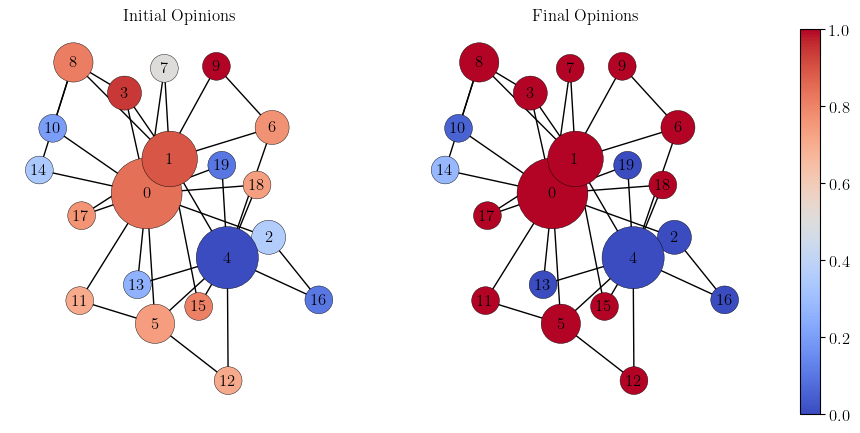

In [56]:
#Here we plot the initial and final opinions of the nodes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
init_color = np.array([bc.G.nodes[node]['initial_opinion'] for node in bc.G.nodes])
final_color = np.array([bc.G.nodes[node]['opinion'] for node in bc.G.nodes])
size = np.array([bc.G.degree[node] for node in bc.G.nodes])
nx.draw(bc.G, pos=nx.kamada_kawai_layout(bc.G), node_color=init_color, node_size=size*200, cmap='coolwarm', with_labels=True, font_size=12, font_color='black', linewidths=0.3, edgecolors='black', ax=ax1)
nx.draw(bc.G, pos=nx.kamada_kawai_layout(bc.G), node_color=final_color, node_size=size*200, cmap='coolwarm', with_labels=True, font_size=12, font_color='black', linewidths=0.3, edgecolors='black', ax=ax2)
ax1.set_title('Initial Opinions')
ax2.set_title('Final Opinions')
plt.colorbar(matplotlib.cm.ScalarMappable(cmap='coolwarm'), ax=[ax1, ax2])
plt.savefig('plots/modified_bounded_confidence_model.png', dpi=300, bbox_inches='tight')
plt.show()


Finally, it is of interest to observe the overall behavior of the model for different combinations of parameters $d_a$ and $d_d$. Keeping $\mu=0.5$ fixed and for $G$ is a Barabási-Albert graph with parameters $n=1000$ and $l=2$, we observe the following behavior:

In [57]:
#Here we define the thresholds we want to test
thresholds = [(0.1, 0.9), (0.1, 0.1), (0.9, 0.9),
                (0.3, 0.7), (0.5, 0.5), (0.5, 0.7)]

#Here we create a Barabasi-Albert graph and run the bounded confidence model for each pair of thresholds
G = nx.barabasi_albert_graph(1000, 2, seed=42)
opinions_list = []
for eps1, eps2 in thresholds:
    bc = BoundedConfidence(G, agreement_threshold=eps1, disagreement_threshold=eps2)
    opinions = bc.run(max_iter=100)
    opinions_list.append(opinions)

100%|██████████| 100/100 [00:00<00:00, 1321.04it/s]


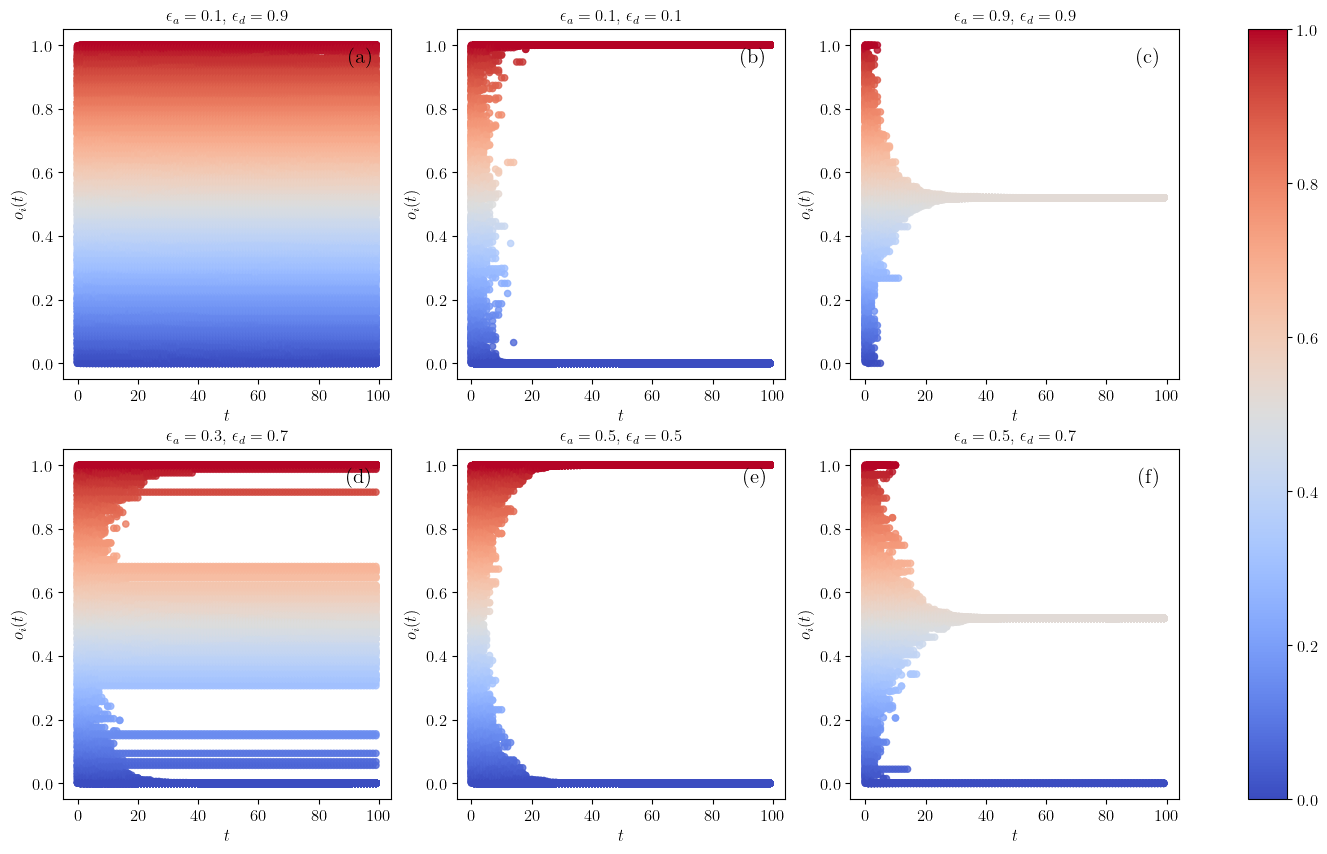

In [101]:
#Here we plot the opinions of the nodes for each pair of thresholds
fig, ax = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = [(0,0,0), (0,1,1), (0,2,2), (1,0,3), (1,1,4), (1,2,5)]
for i,j,z in axes:
    x = [point[0] for point in opinions_list[z]]
    y = [point[1] for point in opinions_list[z]]
    ax[i,j].scatter(x, y, s=20, c=y, marker='o', alpha=0.8, cmap='coolwarm')
    ax[i,j].yaxis.set_tick_params(labelbottom=True)
    ax[i,j].set_xlabel('$t$')
    ax[i,j].set_ylabel('$o_{i}(t)$')
    ax[i,j].set_title(f"$\epsilon_a = {thresholds[z][0]}$, $\epsilon_d = {thresholds[z][1]}$")
    #Here we add an enumeration to the subplots (a), (b), (c), etc. In the top right corner
    ax[i,j].text(0.95, 0.95, f"({chr(97+z)})", transform=ax[i,j].transAxes, fontsize=15, va='top', ha='right', weight='bold')
plt.colorbar(matplotlib.cm.ScalarMappable(cmap='coolwarm'), ax=ax)
plt.savefig('plots/modified_bounded_confidence_model_sims.png', dpi=300, bbox_inches='tight')
plt.show()


As we can see we have some interesting results for extreme cases of the parameters $d_a$ and $d_d$. We can see that for a very small value of $d_a$ and a very high value of $d_d$ (see (a)). agents will not even bother to interact, resulting on opinions spread throughout the set $[0,1]$ (assuming uniform initialization). On the other side, for very small values of $d_a$ and $d_d$ (see (b)), agents will quickly get radicalized, resulting on \textit{polarized} opinions within nodes. Finally, if $d_a$ and $d_d$ have high values  (see (c)), opinions will converge to a common value. There exist other interesting cases, for example on (d), with a smaller value of $d_a$ and a higher value of $d_d$, highly polarized opinions will get radicalized but close enough opinions will be mantained over time, modeling for example an apathic set of agents with a few radical nodes. In general, we conclude that our model effectively accounts for the back-fire effect and that interesting emergent phenomena is observed due to the interaction of radicalized and non-radicalized nodes.

## **Problem 6**

In this last part of the homework, we will make a short report of the application of Graph Neural Networks (GNN's) for Node Classification and Link Prediction making a case study for the [PubMed Dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html). This dataset represents a citation network with nodes representing scientific publications from the PubMed database and edges indicate citations between these publications. Each node features a TF-IDF weighted word vector from the publication’s abstract and a class label that denotes the publication’s subject category.

### **6.1. Exploratory Data Analysis**

In this section we will perform a basic Exploratory Data Analysis in order to analyze the main features of the PubMed dataset. But first we need to upload the dataset from Pytorch Geometric.

In [2]:
#Here we upload the dataset and normalize its features in order to use it in the GNN
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

#Here we print some information about the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3


As we can see, the PubMed has only one citation graph as we mentioned before along with $500$ features that are the TF-IDF values of 500 unique words coming from a dictionary within the articles abstracts. The PubMed dataset has 3 classes. In fact, as we can see here, scientific publications from the PubMed database pertaining to diabetes classified into one of three classes.

Now, we can access the data within the dataset in order to further extend our analysis:

In [3]:
#Here I obtain the first graph object in the dataset
data = dataset[0]

#Now we can print the data to see what it contains
print(data)
print('======================')
#We can obtain some easy information about the dataset
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {round(data.num_edges / data.num_nodes,2)}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of testing nodes: {data.test_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.5
Number of training nodes: 60
Number of testing nodes: 1000
Number of validation nodes: 500
Has isolated nodes: False
Has self-loops: False
Is undirected: True


As we can seem the PubMed dataset defines an undirected graph without self-loops and isolated nodes with average node degree (average citation number) of $4.5$. Moreover, the dataset already contains a separation of the nodes in different training, testing and validation sets, where the training set contains $60$ nodes, the testing set contains $1000$ nodes and the validation set contains $500$ nodes.

#### **6.1.1. Degree Distribution**

It is of intertest to analyze the degree distribution of the network as a whole. To do this, we can convert our data to a NetworkX object in order to manipulate it and plot tehe degree distribution as follows:

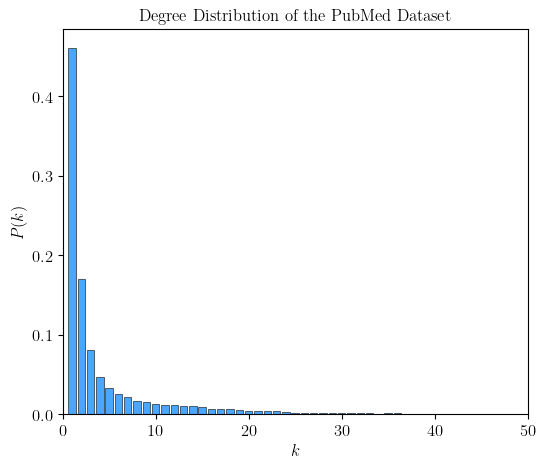

In [94]:
#Here we convert the dataset to a networkx graph
G = to_networkx(data, to_undirected=True)
#Here we obtain a dictionary with the degree of each one of the nodes
degree_distribution = dict(G.degree())
#Here we obtain the x and y values of the degree distribution using the Counter method from the collections library
counter_dict = Counter(degree_distribution.values())
x = np.array(list(counter_dict.keys()))
y = np.array(list(counter_dict.values()))/G.number_of_nodes()

#Here we plot the degree distribution we normalized the y-axis in order to have a probability distribution
plt.figure(figsize=(6, 5))
plt.bar(x, y, color='dodgerblue', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.8)
plt.xlim(0, 50)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.title('Degree Distribution of the PubMed Dataset')
plt.savefig('plots/degree_distribution_pubmed.png', dpi=300, bbox_inches='tight')

Intuitively, a high degree means that the articles were cited by many papers. In other words, nodes with high degrees are likely to be important, at least from the number of citations point of view. We can also observe that the degree distribution seems to follow a Power Law distribution, characteristic of many social networks.

In [98]:
#Here we fit a power law to the degree distribution using the curve_fit method from scipy
#First we define the power law function
def power_law(x, a, b):
    return a*x**b
#Here we fit the power law to the degree distribution
popt, pcov = curve_fit(power_law, x, y)

Now we plot:

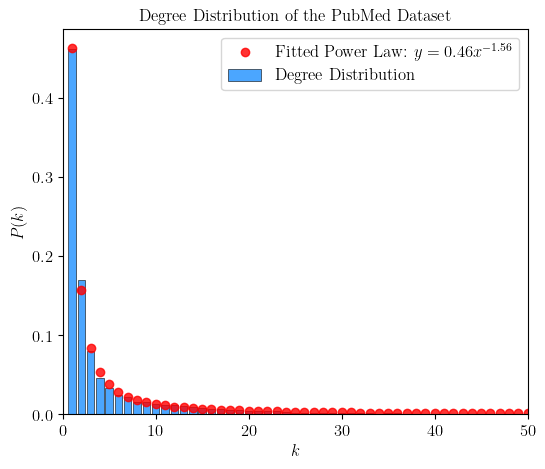

In [99]:
#Now we plot the degree distribution and the fitted power law
plt.figure(figsize=(6, 5))
plt.bar(x, y,  color='dodgerblue', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.8, label='Degree Distribution')
plt.plot(x, power_law(x, *popt), 'o', color='red', alpha=0.8, label=f'Fitted Power Law: $y = {round(popt[0],2)}x^{{{round(popt[1],2)}}}$')
plt.xlim(0, 50)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.title('Degree Distribution of the PubMed Dataset')
plt.legend()
plt.savefig('plots/degree_distribution_pubmed_pl.png', dpi=300, bbox_inches='tight')


#### **6.1.2.Clustering Coefficient**

It is also of interest to obtain the clustering coefficient of the graph. The **clustering coefficient** of an undirected graph is a measure of the degree to which nodes in the graph tend to cluster together. For a node $v$, the  clustering coefficient is the proportion of the number of connections between the node's neighbors to the number of possible connections between those neighbors. It measures the likelihood that the neighbors of a node are also connected to each other. Mathematically:

$$ C_v = \frac{2 \times \text{number of edges between neighbors of } v}{k_v (k_v - 1)} $$


A high clustering coefficient indicates that nodes tend to form tightly knit groups with a high density of ties and a low clustering coefficient indicates that nodes are loosely connected with few triangles formed.


In [101]:
#Here we obtain the clustering coefficient of the graph
clustering_coefficient = nx.average_clustering(G)
print(f'The clustering coefficient of the graph is: {clustering_coefficient}')

The clustering coefficient of the graph is: 0.060175209437523615


This is an almost zero clustering coefficient, meaning that there nodes are very loosely connected with each other (it makes sense, since we saw that there was a low average number of citations).

#### **6.1.3.Homophiliy**

Finally, it is of interest to see if nodes with the same class are more connected to each other than to others in other classes. This property is called *homophily*. We can quantify homophily by observing the probability that nodes of the same class are connected.

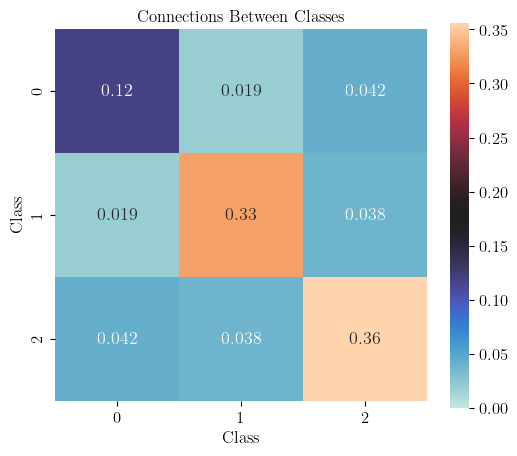

In [116]:
#First we extract all the labels of the nodes
labels_array = data.y.numpy()
#Then we extract the edges of the graph. The edge index is a tensor of shape (2, num_edges) where the first row contains the source nodes and the second row contains the target nodes
edges_array = data.edge_index.numpy()
#Here we define the edge labels array that contains the labels of the source and target nodes of each edge
edge_labels_array = np.array([labels_array[edges_array[0]], labels_array[edges_array[1]]])

#Now we will count the connections between each pair of classes
num_classes = 3
#We initialize a dictionary to store the counts of connections between each pair of classes
connection_counts = {i: {j: 0 for j in range(num_classes)} for i in range(num_classes)}

#Here we count the connections for each pair of classes
for i, j in zip(edge_labels_array[0], edge_labels_array[1]):
    if i < num_classes and j < num_classes:
        connection_counts[i][j] += 1

#Here we create a matrix with the counts of connections between each pair of classes
connection_matrix = np.array([[connection_counts[i][j] for j in range(num_classes)] for i in range(num_classes)])
#We can normalize the matrix dividing each entry by the total number of connections
connection_matrix = connection_matrix/np.sum(connection_matrix)

#Here we plot the connection matrix as a heatmap
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(connection_matrix, annot=True, cmap='icefire', cbar=True, square=True, vmin=0, vmax=np.max(connection_matrix))
plt.xlabel('Class')
plt.ylabel('Class')
plt.title('Connections Between Classes')
plt.savefig('plots/conn_class.png', dpi=300, bbox_inches='tight')


#### **6.1.4.Number of Classes**

Now, it is important to observe the distribution of the classes of the dataset in order to assess any imbalance in the graph.

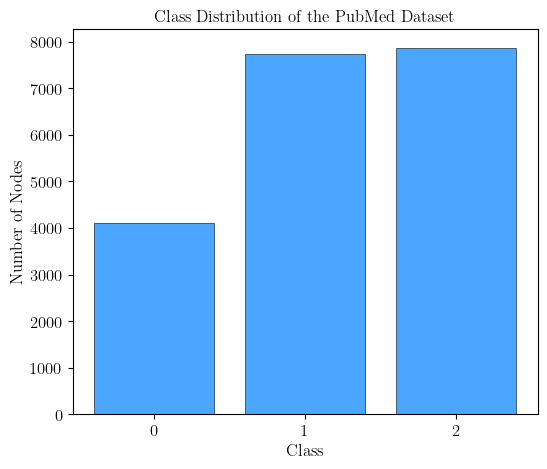

In [126]:
#Here we count the number of nodes of each class
class_counter = dict(Counter(data.y.numpy()))

#Now we plot the number of nodes of each class.
plt.figure(figsize=(6, 5))
plt.bar(class_counter.keys(), class_counter.values(), color='dodgerblue', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.8)
plt.xlabel('Class')
plt.xticks(range(num_classes))
plt.ylabel('Number of Nodes')
plt.title('Class Distribution of the PubMed Dataset')
plt.savefig('plots/class_distribution.png', dpi=300, bbox_inches='tight')

As we can see there are way less nodes of class 0 in comparison to the other two classes. This is important since any class imbalance can propagate into the training of the GNN's. Now, let's observe how these classes are distributed in the training, testing and validation sets:

As we can see there is indeed more probability of having a connection between nodes in the PubMed dataset although values are not very high.

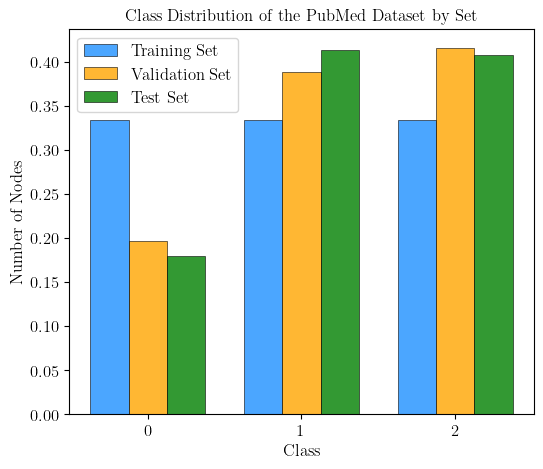

In [132]:
#Here we count the number of nodes of each class in the training, validation and test sets
class_counter_train = dict(Counter(data.y[data.train_mask].numpy()))
class_counter_val = dict(Counter(data.y[data.val_mask].numpy()))
class_counter_test = dict(Counter(data.y[data.test_mask].numpy()))

#Now we plot the number of nodes of each class in the training, validation and test sets
#We normalize the y-axis in order to have a probability distribution and compare the class distribution in the different sets
plt.figure(figsize=(6, 5))
plt.bar(np.array(list(class_counter_train.keys()))-0.25, np.array(list(class_counter_train.values()))/np.sum(list(class_counter_train.values())), color='dodgerblue', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.25, label='Training Set')
plt.bar(np.array(list(class_counter_val.keys())), np.array(list(class_counter_val.values()))/np.sum(list(class_counter_val.values())), color='orange', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.25, label='Validation Set')
plt.bar(np.array(list(class_counter_test.keys()))+0.25, np.array(list(class_counter_test.values()))/np.sum(list(class_counter_test.values())), color='green', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.25, label='Test Set')

plt.xlabel('Class')
plt.xticks(range(num_classes))
plt.ylabel('Number of Nodes')
plt.title('Class Distribution of the PubMed Dataset by Set')
plt.legend()
plt.savefig('plots/class_distribution_sets.png', dpi=300, bbox_inches='tight')

As we can observe, the training set eliminates this imbalance of classes, ensuring a correct training of the GNN's, the same does't happen for the other categories.

#### **6.1.5.Spread of TFIDF values**

Now, it is of interest to observe the spread of the TFIDF values and observe it also by dataset in order to see if there are words that are more frequent than others.

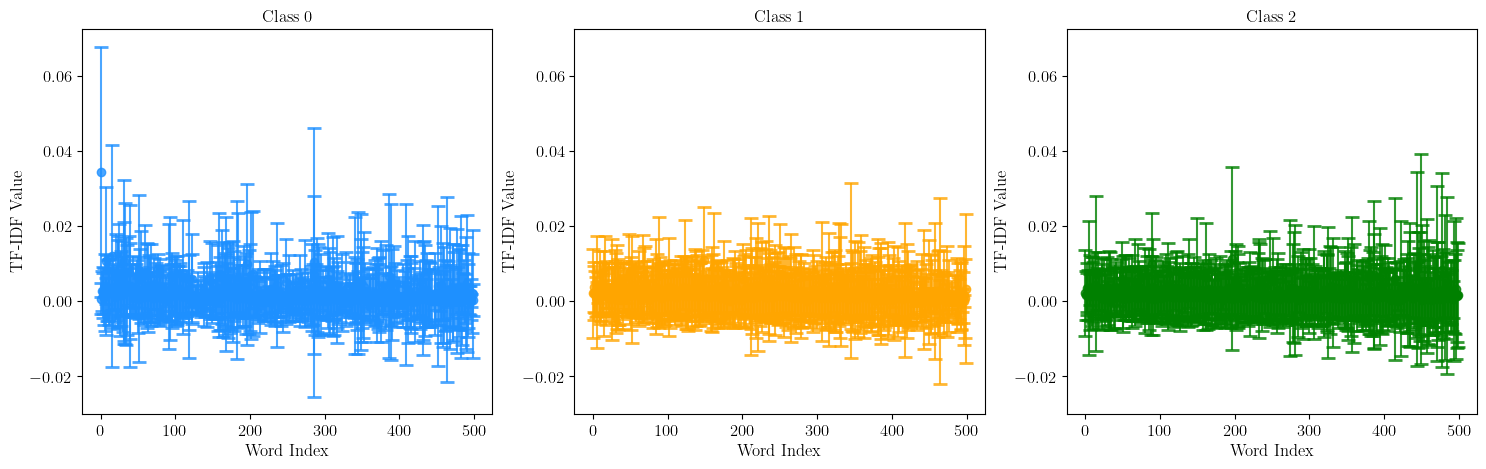

In [142]:
#The node features are TF-IDF coefficients associated with each word in the vocabulary
#Here we analyze the spread of the features of the nodes by plotting the mean and standard deviation of the features for each class
#First we extract the node features
features_array = data.x.numpy()
#Then we extract the labels of the nodes
labels_array = data.y.numpy()
#Here we define the features of the nodes of each class
features_class = {i: features_array[labels_array == i] for i in range(num_classes)}
#Here we compute the mean and standard deviation of the features for each class
mean_features = {i: np.mean(features_class[i], axis=0) for i in range(num_classes)}
std_features = {i: np.std(features_class[i], axis=0) for i in range(num_classes)}

#Now we plot the mean and standard deviation of the features for each class
#We plot it in three subplots, one for each class that share the same y-axis
#Here we define the colors for each class
colors = ['dodgerblue', 'orange', 'green']
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i in range(num_classes):
    ax[i].errorbar(range(len(mean_features[i])), mean_features[i], yerr=std_features[i], fmt='o', color=colors[i], alpha=0.8, capsize=5, capthick=2)
    ax[i].yaxis.set_tick_params(labelbottom=True)
    ax[i].set_xlabel('Word Index')
    ax[i].set_ylabel('TF-IDF Value')
    ax[i].set_title(f'Class {i}')
#Here we save the plot
plt.savefig('plots/feature_spread.png', dpi=300, bbox_inches='tight')

### **6.2. Introduction to GNN's**

Before delving fully into using GNN's to perform classification or prediction tasks, let's make a quick introduction of what they are and how are they useful.

Graph Neural Networks (GNNs) are a class of deep learning models that operate on graph inputs. These networks have gained immense popularity in recent years because of their wide applicability in domains such as knowledge graphs, social networks and molecular biology. They can be used to learn embeddings for graph entities (nodes, edges, or entire graphs) and have shown remarkable performance on tasks like graph classification, node classification, link prediction and so on.


<p align="center">
<img src="images/gnn.gif" style="width:500px;height:300px;">
<p align="center">
<em>Fig 2: Mechanics behind a single layer of a GNN.</em>
</p>

The common theme to any type of GNN is that it implements some form of neural message passing, whereby messages (in the form of vectors) are exchanged between the nodes of the graph to iteratively update the internal representations of the graph’s nodes. Formally, given a graph $G=(V,E)$ along with any relevant node features $\vec{X} \in \mathbf{R}^{d_{0} \times n}$, a GNN can be used to generate node embeddings $\vec{p}_{v}, \forall v \in V$. This is done iteratively as follows:

- Consider hidden embedding vectors $\{\vec{h}^{k}_{v}\}$ representing each node $v\in V$. In each iteration $k$, every embedding vector $\vec{h}^{k}_{v}$ is updated based on information inferred from the corresponding local neighborhood, denoted as $\mathbf{N}_{v} = \{u\in V | (u,v)\in E\}$.

At layer (iteration) $k=0$, the initial representations $\vec{h}^{0}_{v} \in \mathbf{R}^{d_{0}}$ are usually derived from the node's labels or given input features of dimensionality $d_{0}$.

This single layer update can then be formalized as:
$$\vec{m}_{v}^{k} = \text{AGGREGATE}^{k}_{\theta} \left(\vec{h}_{u}^{k-1}|u\in\mathbf{N}_{v}\right)$$
$$\vec{h}_{v}^{k} = \text{UPDATE}^{k}_{\theta} \left(\vec{h}_{v}^{k-1}, \vec{m}_{v}^{k}\right)$$

for the GNN layers (iterations) $k=1, \dots, K$ with $\text{AGGREGATE}(\cdot)$ and $\text{UPDATE}(\cdot)$ referring to some differentiable functions.

The vector $\vec{m}_{v}^{k}$ represents the $k$-th layer message for node $v=1,\dots,n$ as aggregated from the corresponding local graph neighborhood $\mathbf{N}_{v}$. At each iteration $k$, every node aggregates information from its local neighborhood, and as these iterations progress each node embedding encapsulates a larger receptive field within the graph.


<p align="center">
<img src="images/gnn2.png" style="width:600px;height:300px;">
<p align="center">
<em>Fig 2: A stack of GNN layers operating.</em>
</p>

Specifically, after $k$ iterations every node embedding contains information about its $k$-hop neighborhood, with the final output (after $K$ iterations of message passing) defined as $\vec{p}_{v} = \vec{h}^{K}_{v}$. This output can then be used for prediction tasks, such as node classification or link prediction. To optimize the predictive power of this approach, the final node embeddings $\vec{p}_{v} = \vec{h}^{K}_{v}$ are fed into a problem-specific loss function, with some form of stochastic gradient descent optimizing the weight parameters of the network.

In this project, we will explore three different GNN architectures based on the three most popular GNN models: GCN, GraphSAGE and GAT. Here is a brief description of how they work:

#### **6.2.1.- Graph Convolutional Networks (GCN)**

Most existing GNN algorithms can be written in the format given on section 1.2, and different choices for aggregate and combine functions yield different GNN models. The first of the ones used for this project is called Graph Convolutional Network (or GCN).

In this model, the aggregate and combine functions are integrated into the following process:

$$ \vec{h}_{v}^{k} = \sigma \left(W_{k} \sum_{u\in \mathbf{N}_{v}\cup \{v\}} \frac{\vec{h}_{u}^{k-1}}{\sqrt{d_{u}d_{v}}} \right)$$

with $W_{k}$ is a shared trainable weight matrix, the denominator serves as a normalization factor, where $d_{v}$ is the degree of node $v$ and $\sigma(\cdot)$ being some nonlinear activation function, like eLU or ReLU.

#### **6.2.2.- GraphSAGE**

The GraphSAGE model was one of the first models to propose the ability to generalize to unseen nodes during inference. While the original paper presents various options for the aggregate function, the one we'll use in this project is the mean aggregator, where we simply take the elementwise mean of the vectors in $\{\vec{h}_{u}^{k-1}, \forall u\in \mathbf{N}_{v}\}$. The mean aggregator is nearly equivalent to the convolutional propagation rule used in the transductive GCN framework. In particular, we use a variant of the GCN approach defined as follows:

$$ \vec{h}_{v}^{k} = \sigma \left(W_{k} \cdot \text{CONCAT}\left(\vec{h}_{v}^{k-l}, \text{MEAN}\left(\{\vec{h}_{u}^{k-l}, \forall u \in \mathbf{N}_{v}\} \right) \right) \right)$$

with $W_{k}$ is a shared trainable weight matrix and $\sigma(\cdot)$ being some nonlinear activation function, like eLU or ReLU.

#### **6.2.3.- Graph Attention Networks (GAT)**

Graph Attention Networks (GATs) are a variant of Graph Neural Networks (GNNs) that leverage attention mechanisms for feature learning on graphs. Standard GNNs, such as Graph Convolutional Networks (GCNs), do not differentiate between the contributions of different neighbors. GATs, on the other hand, assign an attention coefficient to each neighbor, indicating the importance of that neighbor’s features for the feature update of the node. The aggregation and update functions are modified to include attention coefficients, which are calculated as follows:

First, for each node $v$, we compute a set of unnormalized attention coefficients with each of its neighbors $u \in \mathbf{N}_{v}$:

$$ e_{vu} = \text{LeakyReLU}\left( \vec{a}^{\top} \left[W \vec{h}_{v} \parallel W \vec{h}_{u} \right] \right) $$

where $\vec{a}$ is a learnable weight vector, $W$ is a shared weight matrix, and $\parallel$ denotes concatenation.

These coefficients are then normalized using the softmax function:

$$ \alpha_{vu} = \text{softmax}_{u} (e_{vu}) = \frac{\exp(e_{vu})}{\sum_{k \in \mathbf{N}_{v}} \exp(e_{vk})} $$

The normalized attention coefficients $\alpha_{vu}$ indicate the importance of node $u$'s features to node $v$.

Next, the node embeddings are updated by computing a weighted sum of the features of neighboring nodes:

$$ \vec{h}_{v}^{k} = \sigma \left( \sum_{u \in \mathbf{N}_{v}} \alpha_{vu} W \vec{h}_{u}^{k-1} \right) $$

where $\sigma(\cdot)$ is a nonlinear activation function, such as eLU or ReLU.

GAT layers can be stacked to create deeper models, allowing the network to capture more complex relationships in the graph. After $K$ layers, the final node embeddings $\vec{p}_{v} = \vec{h}^{K}_{v}$ can be used for various downstream tasks, similar to other GNN architectures.



### **6.3. Node Classification**

#### **6.3.1.- The GNN Architecture**

In this project, we use a simple two-layer GNN architecture based on PyTorch GCN, GraphSAGE and GAT units. For the whole three models we followed the same steps of construction:

- The first GNN layer is fed the initial node embeddings $\vec{h}^{0}_{v}$ of dimension $d_{0}$  (these embeddings contain the features of the graph, in our case, the TF-IDF values) and outputs a representation of size $d_{1}$.

- Next, we apply a component-wise, non-linear ReLU transformation (In order to prevent overfitting, we add a probability of dropout as well).

- The second GCN(GraphSAGE) layer is then fed a intermediate representation vector $\vec{h}^{1}_{v}$  and outputs a layer of size $d_{2} = q$, where $q$ is the number of classes in which the nodes of the graph will be classified.

- Finally, the output is fed through a component-wise softmax transformation to provide one-hot encoded $q$-dimensional probabilistic node assignments $\vec{p}_{v} \in [0,1]^{q}$ that represent the probabilities that each node belongs to a given class.

These architectures were implemented in the ``gnn.py`` module via the ``GCN``, ``SAGE`` and  ``GAT`` classes utilizing the ``PyTorch Geometric`` module and functions.

In order to make comparisons and tuning the loss obtained when training our GNN models, we performed two approaches when training each one of our GNN models:

- In a first approach we trained our GNN models by fully considering all the training nodes in our training set. This potentially would overfit the model since we are considering a big quantity of nodes that may be irrelevant when obtaining the embedding of another node.

- In a second approach we performed *Neighbor Sampling*. The basic idea of this is that for every node, instead of using the entire neighborhood information (i.e., all connected $k$-hop neighbors), we select or sample a subset of them to perform the aggregation needed in graph embedding. This could be benefitial to avoid overfitting and high computational cost.



#### **6.3.2.- GCN: Training and Results**

Here we can finally train our GCN Model and compare the results obtained when using and not using Neighbor Sampling.

In [4]:
# Here we set the device: GPU/CPU and the type of the tensors to use
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

# Here we fix a seed to ensure consistent results
SEED_VALUE = 8111

Will use device: cpu, torch dtype: torch.float32


Here we initialize the hyperparameters of our model and perform training without Neighbor Sampling:

In [11]:
#Here we define the hyperparameters
hypers = {
    'model': "GCN",  # Which model to use
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'out_dim': dataset.num_classes,  # Output dimension of the model
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(300),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
node_class = NodeClassification(data, hypers)
train_losses, val_losses = node_class.training(verbose=False)
#At the end we print the metrics of the model
metrics = node_class.test()
metrics

Setting seed to 8111...
Building GCN model...
Building ADAM optimizer...
Setting seed to 8111...


{'accuracy': 0.796,
 'precision': 0.7932208163141276,
 'recall': 0.7892846291151375,
 'f1_score': 0.7903966386221839}

We can do the same but performing Neighbor Sampling:

In [12]:
#Here we define the hyperparameters
hypers = {
    'model': "GCN",  # Which model to use
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'out_dim': dataset.num_classes,  # Output dimension of the model
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(300),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
node_class = NodeClassification(data, hypers)
train_losses_samp, val_losses_samp = node_class.training_neighbor_sampling(verbose=False)
#At the end we print the metrics of the model
metrics = node_class.test()
metrics

Setting seed to 8111...
Building GCN model...
Building ADAM optimizer...
Setting seed to 8111...


{'accuracy': 0.785,
 'precision': 0.775765918845961,
 'recall': 0.7887406997576489,
 'f1_score': 0.7813601835180254}

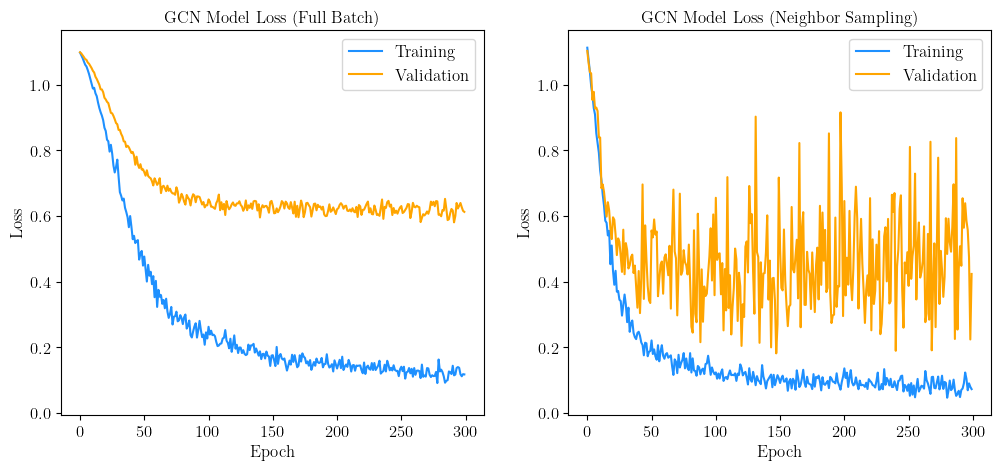

In [15]:
#Finally we plot the training and validation losses of the two models side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(train_losses, label='Training', color='dodgerblue')
ax[0].plot(val_losses, label='Validation', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('GCN Model Loss (Full Batch)')
ax[0].yaxis.set_tick_params(labelbottom=True)
ax[0].legend()
#Here we plot the training and validation losses of the two models side by side
ax[1].plot(train_losses_samp, label='Training', color='dodgerblue')
ax[1].plot(val_losses_samp, label='Validation', color='orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('GCN Model Loss (Neighbor Sampling)')
ax[1].yaxis.set_tick_params(labelbottom=True)
ax[1].legend()
#Here we save the plot
plt.savefig('plots/gcn_losses.png', dpi=300, bbox_inches='tight')


We can see that even though the test accuracy is higher for the full batch training, the validation loss stops descending after some iterations. This problem however was not solved entirely by mini batch training as we can see from the plot in the right.

#### **6.3.3.- GraphSAGE: Training and Results**

Here we can finally train our GraphSAGE Model and compare the results obtained when using and not using Neighbor Sampling. First we do full batch training:

In [16]:
#Here we define the hyperparameters
hypers = {
    'model': "GraphSAGE",  # Which model to use
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'out_dim': dataset.num_classes,  # Output dimension of the model
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(300),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
node_class = NodeClassification(data, hypers)
train_losses, val_losses = node_class.training(verbose=False)
#At the end we print the metrics of the model
metrics = node_class.test()
metrics

Setting seed to 8111...
Building GraphSAGE model...
Building ADAM optimizer...
Setting seed to 8111...


{'accuracy': 0.769,
 'precision': 0.7634102020042723,
 'recall': 0.7673262851228952,
 'f1_score': 0.7645318461667875}

We can do the same but performing Neighbor Sampling:

In [17]:
#Here we define the hyperparameters
hypers = {
    'model': "GraphSAGE",  # Which model to use
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'out_dim': dataset.num_classes,  # Output dimension of the model
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(300),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
node_class = NodeClassification(data, hypers)
train_losses, val_losses = node_class.training_neighbor_sampling(verbose=False)
#At the end we print the metrics of the model
metrics = node_class.test()
metrics

Setting seed to 8111...
Building GraphSAGE model...
Building ADAM optimizer...
Setting seed to 8111...


{'accuracy': 0.769,
 'precision': 0.7704125148246335,
 'recall': 0.7653557695930577,
 'f1_score': 0.7676968145300315}

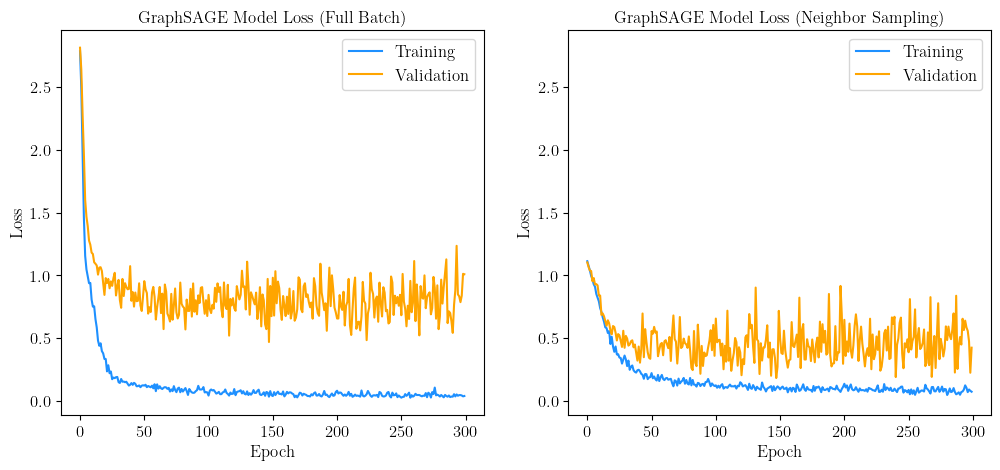

In [18]:
#Finally we plot the training and validation losses of the two models side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(train_losses, label='Training', color='dodgerblue')
ax[0].plot(val_losses, label='Validation', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('GraphSAGE Model Loss (Full Batch)')
ax[0].yaxis.set_tick_params(labelbottom=True)
ax[0].legend()
#Here we plot the training and validation losses of the two models side by side
ax[1].plot(train_losses_samp, label='Training', color='dodgerblue')
ax[1].plot(val_losses_samp, label='Validation', color='orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('GraphSAGE Model Loss (Neighbor Sampling)')
ax[1].yaxis.set_tick_params(labelbottom=True)
ax[1].legend()
#Here we save the plot
plt.savefig('plots/gsage_losses.png', dpi=300, bbox_inches='tight')


We can see that we obtained similar accuracy values but loss was minimized in a better fashion by using Mini Batch training.

#### **6.3.4.- GAT: Training and Results**

Here we can finally train our GAT Model and compare the results obtained when using and not using Neighbor Sampling. First we do full batch training:

In [19]:
#Here we define the hyperparameters
hypers = {
    'model': "GAT",  # Which model to use
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'out_dim': dataset.num_classes,  # Output dimension of the model
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(300),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
node_class = NodeClassification(data, hypers)
train_losses, val_losses = node_class.training(verbose=False)
#At the end we print the metrics of the model
metrics = node_class.test()
metrics

Setting seed to 8111...
Building GAT model...
Building ADAM optimizer...
Setting seed to 8111...


{'accuracy': 0.778,
 'precision': 0.7833805580608649,
 'recall': 0.7601302931811406,
 'f1_score': 0.7695340985907562}

We can do the same but performing Neighbor Sampling:

In [20]:
#Here we define the hyperparameters
hypers = {
    'model': "GAT",  # Which model to use
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 16,      # Hidden dimension of the model
    'out_dim': dataset.num_classes,  # Output dimension of the model
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(300),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
node_class = NodeClassification(data, hypers)
train_losses, val_losses = node_class.training_neighbor_sampling(verbose=False)
#At the end we print the metrics of the model
metrics = node_class.test()
metrics

Setting seed to 8111...
Building GAT model...
Building ADAM optimizer...
Setting seed to 8111...


{'accuracy': 0.687,
 'precision': 0.6938316530093077,
 'recall': 0.7241759589217217,
 'f1_score': 0.6796551364418661}

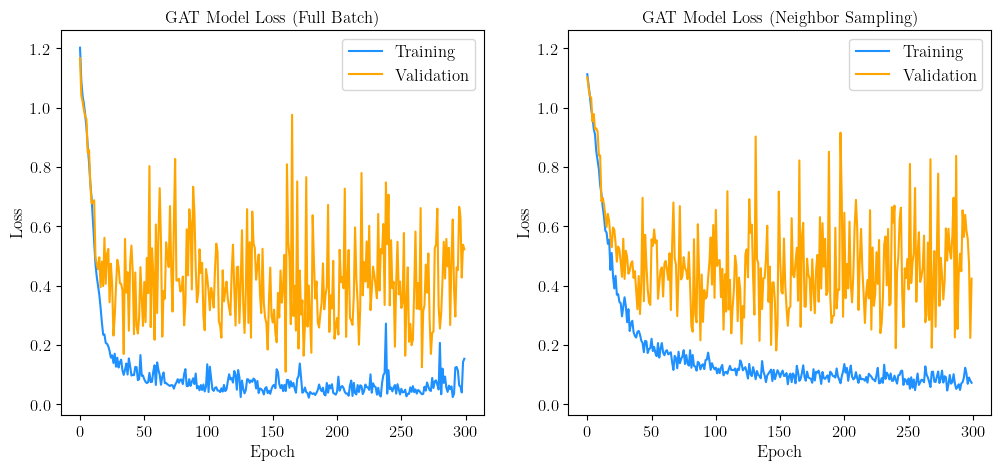

In [21]:
#Finally we plot the training and validation losses of the two models side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(train_losses, label='Training', color='dodgerblue')
ax[0].plot(val_losses, label='Validation', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('GAT Model Loss (Full Batch)')
ax[0].yaxis.set_tick_params(labelbottom=True)
ax[0].legend()
#Here we plot the training and validation losses of the two models side by side
ax[1].plot(train_losses_samp, label='Training', color='dodgerblue')
ax[1].plot(val_losses_samp, label='Validation', color='orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('GAT Model Loss (Neighbor Sampling)')
ax[1].yaxis.set_tick_params(labelbottom=True)
ax[1].legend()
#Here we save the plot
plt.savefig('plots/gat_losses.png', dpi=300, bbox_inches='tight')


We can observe that the loss plots seem very similar but GAT suffered the most from doing mini batch training since its accuracy descended from $0.778$ to almost $0.68$.

### **6.4. Link Prediction**

Link prediction on GNN's is trickier than node classification since we need a more complex architecture to make predictions on edges using node embeddings. The steps that are normally followed during link prediction steps are described below:

- We create a GCN Model *encoder* that creates node embeddings by processing the graph with two GCN layers.

- After doing this we randomly add *negative* links to the original graph. This induces a model task: binary classification, since we need to classify the positive links from the original edges and the negative links from the added edges.

- We create a *decoder* which makes link predictions (i.e. binary classifications) on all the edges including the negative links using node embeddings. The decoder normally calculates a dot product of the node embeddings from pair of nodes on each edge. Then, it aggregates the values across the embedding dimension and creates a single value on every edge that represents the *probability* of edge existence.

An architecture diagram of this process can be seen below:

<p align="center">
<img src="images/linkpred.png" style="width:500px;height:300px;">
<p align="center">
<em>Fig 3: Mechanics behind a link prediction using GNN's.</em>
</p>

Notice that in this case we will need to create our own Training, Testing and Validation Data. We can do this using the `RandomLinkSplit` method of Pytorch Geometric.

In [5]:
#Here we perform the link split into training, validation and test sets
#The num_val parameter specifies the percentage of edges to use for the validation set
#The num_test parameter specifies the percentage of edges to use for the test set
#The add_negative_train_samples parameter specifies whether to add negative samples to the training set
#In this case we don't since we are going to do it in the training loop
#The neg_sampling_ratio parameter specifies the ratio of negative samples to add to the training set
split = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)

#Here we split the dataset into training, validation and test sets  
train_data, val_data, test_data = split(data)

Now we are ready to perform our Link Prediction task:

In [6]:
#Here we define the hyperparameters for link prediction
hypers = {
    'model': "GCN",  # Which model to use
    #Since this is a link prediction task the initial dimension should be the number of features of the nodes
    'initial_dim': dataset.num_features,  # Dimension of the initial embedding
    'hidden_dim': 250,      # Hidden dimension of the model
    'out_dim': 125,  # Output dimension of the model. It needs not to be the number of classes since this is a link prediction task
    'dropout': 0.5,     # Dropout rate
    'learning_rate': 0.01, # Learning rate
    'weight_decay': 5e-4,   # Weight decay
    'number_epochs': int(100),   # Max number training steps
    'seed': SEED_VALUE,    # Random seed
    'device': TORCH_DEVICE, # Device to use
    'dtype': TORCH_DTYPE,   # Data type to use
}
link_class = LinkPrediction(train_data, hypers)
train_losses = link_class.training(verbose=True)
#At the end we print the metrics of the model
metrics = link_class.test(test_data)
metrics

Setting seed to 8111...
Building GCN model...
Building ADAM optimizer...
Setting seed to 8111...
Epoch: 0 | Loss: 0.6929720640182495
Epoch: 50 | Loss: 0.6107448935508728


{'roc_auc': 0.855402923764157, 'hits_at_1': 1.0}

As we can see we obtained a ROC-AUC value of roughly 86%, this is not bad but it could be better if we tune the hyperparameters of course. We also calculated the Hits@1 metric, this is a metric that evaluates the accuracy of the model by measuring how often the top-ranked item in the recommendation list matches the ground truth. For our model, Hits@1 indicates the percentage of times the top-ranked item recommended by the model is indeed the correct item. We obtained the maximum result, although it may be wrong for some reason.

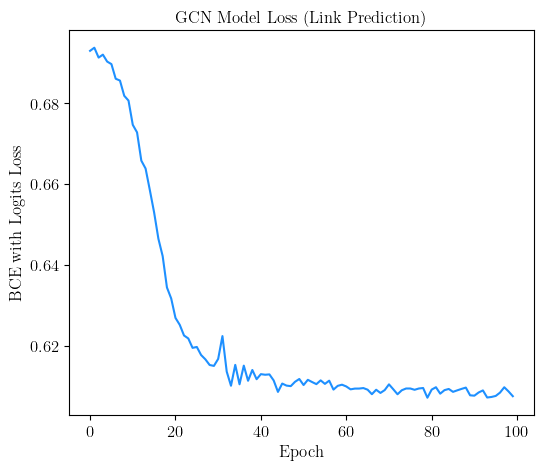

In [8]:
#Here we plot the training loss of the model
plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Training', color='dodgerblue')
plt.xlabel('Epoch')
plt.ylabel('BCE with Logits Loss')
plt.title('GCN Model Loss (Link Prediction)')
plt.savefig('plots/gcn_link_losses.png', dpi=300, bbox_inches='tight')